<a href="https://colab.research.google.com/github/donghuna/AI-Expert/blob/main/%EC%9D%B4%EC%9E%AC%EC%9C%A4/%5B240703%5D_HuggingfaceTutorial_PLM_FineTuning(%EB%B0%B0%ED%8F%AC%EC%9A%A9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TA recitation: Huggingface Transformers Library

This notebook will give an introduction to the Hugging Face Transformers Python library and some common patterns that you can use to take advantage of it. It is most useful for using or fine-tuning pretrained transformer models for your projects.


Hugging Face provides access to models (both the code that implements them and their pre-trained weights), model-specific tokenizers, as well as pipelines for common NLP tasks, and datasets and metrics in a separate `datasets` package. It has implementations in PyTorch, Tensorflow, and Flax (though we'll be using the PyTorch versions here!)


We're going to go through a few use cases:
* Overview of Tokenizers and Models
* Finetuning: We'll use a sentiment-classification example.

Here are additional resources introducing the library that were used to make this tutorial:

* [Hugging Face Docs](https://huggingface.co/docs/transformers/index)
  * Clear documentation
  * Tutorials, walk-throughs, and example notebooks
  * List of available models
* [Hugging Face Course](https://huggingface.co/course/)

In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate -U

In [ ]:
mkdir checkpoints

In [ ]:
from collections import defaultdict, Counter
import json

from matplotlib import pyplot as plt
import numpy as np
import torch

def print_encoding(model_inputs, indent=4):
    indent_str = " " * indent
    print("{")
    for k, v in model_inputs.items():
        print(indent_str + k + ":")
        print(indent_str + indent_str + str(v))
    print("}")

## Part 0: Common Pattern for using Hugging Face Transformers

We're going to start off with a common usage pattern for Hugging Face Transformers, using the example of Sentiment Analysis.

First, find a model on [the hub](https://huggingface.co/models). Anyone can upload their model for other people to use. (I'm using a sentiment analysis model from [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3489963)).

Then, there are two objects that need to be initialized - a **tokenizer**, and a **model**

* Tokenizer converts strings to lists of vocabulary ids that the model requires
* Model takes the vocabulary ids and produces a prediction


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# siebert: https://huggingface.co/siebert/sentiment-roberta-large-english
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

In [ ]:
inputs = ["I'm excited to learn about Hugging Face Transformers!", "It's boring to learn about Hugging Face Transformers"]


for input in inputs:
    tokenized_inputs = tokenizer(input, return_tensors="pt")
    outputs = model(**tokenized_inputs)
    labels = ['NEGATIVE', 'POSITIVE']
    prediction = torch.argmax(outputs.logits)
    print("Input:")
    print(input)
    print()
    print("Tokenized Inputs:")
    print_encoding(tokenized_inputs)
    print()
    print("Model Outputs:")
    print(outputs)
    print()
    print(f"The prediction is {labels[prediction]}")
    print()
    print('***')

### 0.1 Tokenizers

Pretrained models are implemented along with **tokenizers** that are used to preprocess their inputs. The tokenizers take raw strings or list of strings and output what are effectively dictionaries that contain the model inputs.


You can access tokenizers either with the Tokenizer class specific to the model you want to use (here DistilBERT), or with the AutoTokenizer class.
Fast Tokenizers are written in Rust, while their slow versions are written in Python.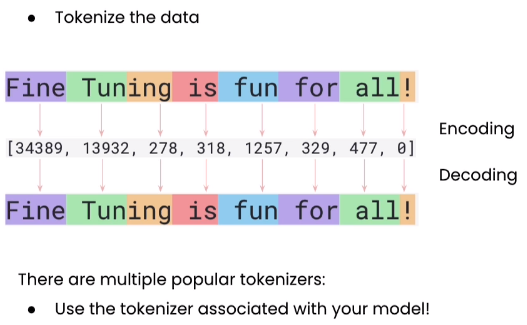

In [ ]:
from transformers import DistilBertTokenizer, DistilBertTokenizerFast, AutoTokenizer
# https://huggingface.co/docs/transformers/en/model_doc/distilbert
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")      # written in Python
print(tokenizer)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-cased")  # written in Rust
print(tokenizer)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased") # convenient! Defaults to Fast
print(tokenizer)

In [ ]:
# This is how you call the tokenizer
input_str = "Hugging Face Transformers is great!"
tokenized_inputs = tokenizer(input_str)


print("Vanilla Tokenization")
print_encoding(tokenized_inputs)
print()

# Two ways to access:
print(tokenized_inputs.input_ids)
print(tokenized_inputs["input_ids"])

In [ ]:
#"##" means that the rest of the token should be attached to the previous one

cls = [tokenizer.cls_token_id]
sep = [tokenizer.sep_token_id]

# Tokenization happens in a few steps:
input_tokens = tokenizer.tokenize(input_str)
input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
input_ids_special_tokens = cls + input_ids + sep

decoded_str = tokenizer.decode(input_ids_special_tokens)

print("start:                ", input_str)
print("tokenize:             ", input_tokens)
print("convert_tokens_to_ids:", input_ids)
print("add special tokens:   ", input_ids_special_tokens)
print("--------")
print("decode:               ", decoded_str)

# NOTE that these steps don't create the attention mask or add the special characters

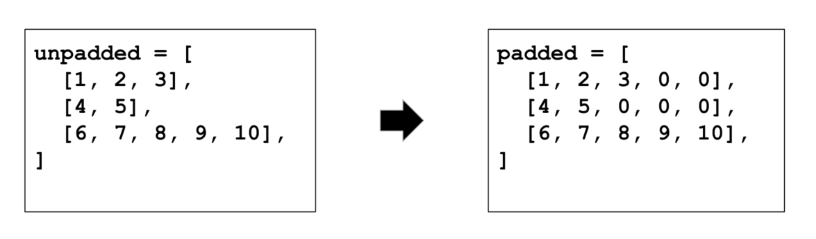

In [ ]:
# You can pass multiple strings into the tokenizer and pad them as you need
model_inputs = tokenizer(["Hugging Face Transformers is great!",
                         "The quick brown fox jumps over the lazy dog." +\
                         "Then the dog got up and ran away because she didn't like foxes.",
                         ],
                         return_tensors="pt",
                         padding=True,
                         truncation=True)
print(f"Pad token: {tokenizer.pad_token} | Pad token id: {tokenizer.pad_token_id}")
print("Padding:")
print_encoding(model_inputs)

In [ ]:
# You can also decode a whole batch at once:
print("Batch Decode:")
print(tokenizer.batch_decode(model_inputs.input_ids))
print()
print("Batch Decode: (no special characters)")
print(tokenizer.batch_decode(model_inputs.input_ids, skip_special_tokens=True))

For more information about tokenizers, you can look at:
[Hugging Face Transformers Docs](https://huggingface.co/docs/transformers/main_classes/tokenizer) and the [Hugging Face Tokenizers Library](https://huggingface.co/docs/tokenizers/python/latest/quicktour.html) (For the Fast Tokenizers). The Tokenizers Library even lets you train your own tokenizers!

### 0.2 Models




Initializing models is very similar to initializing tokenizers. You can either use the model class specific to your model or you can use an AutoModel class. I tend to prefer AutoModel, especially when I want to compare models, because it's easy to specify the models as strings.

While most of the pretrained transformers have similar architecture, if there are additional weights, called "heads" that you have to train if you're doing sequence classification, question answering, or some other task. Hugging Face automatically sets up the architecture you need when you specify the model class. For example, we are doing sentiment analysis, so we are going to use `DistilBertForSequenceClassification`. If we were going to continue training DistilBERT on its masked-language modeling training objective, we would use `DistilBertForMaskedLM`, and if we just wanted the model's representations, maybe for our own downstream task, we could just use `DistilBertModel`.


Here's a stylized picture of a model recreated from one found here: [https://huggingface.co/course/chapter2/2?fw=pt](https://huggingface.co/course/chapter2/2?fw=pt).
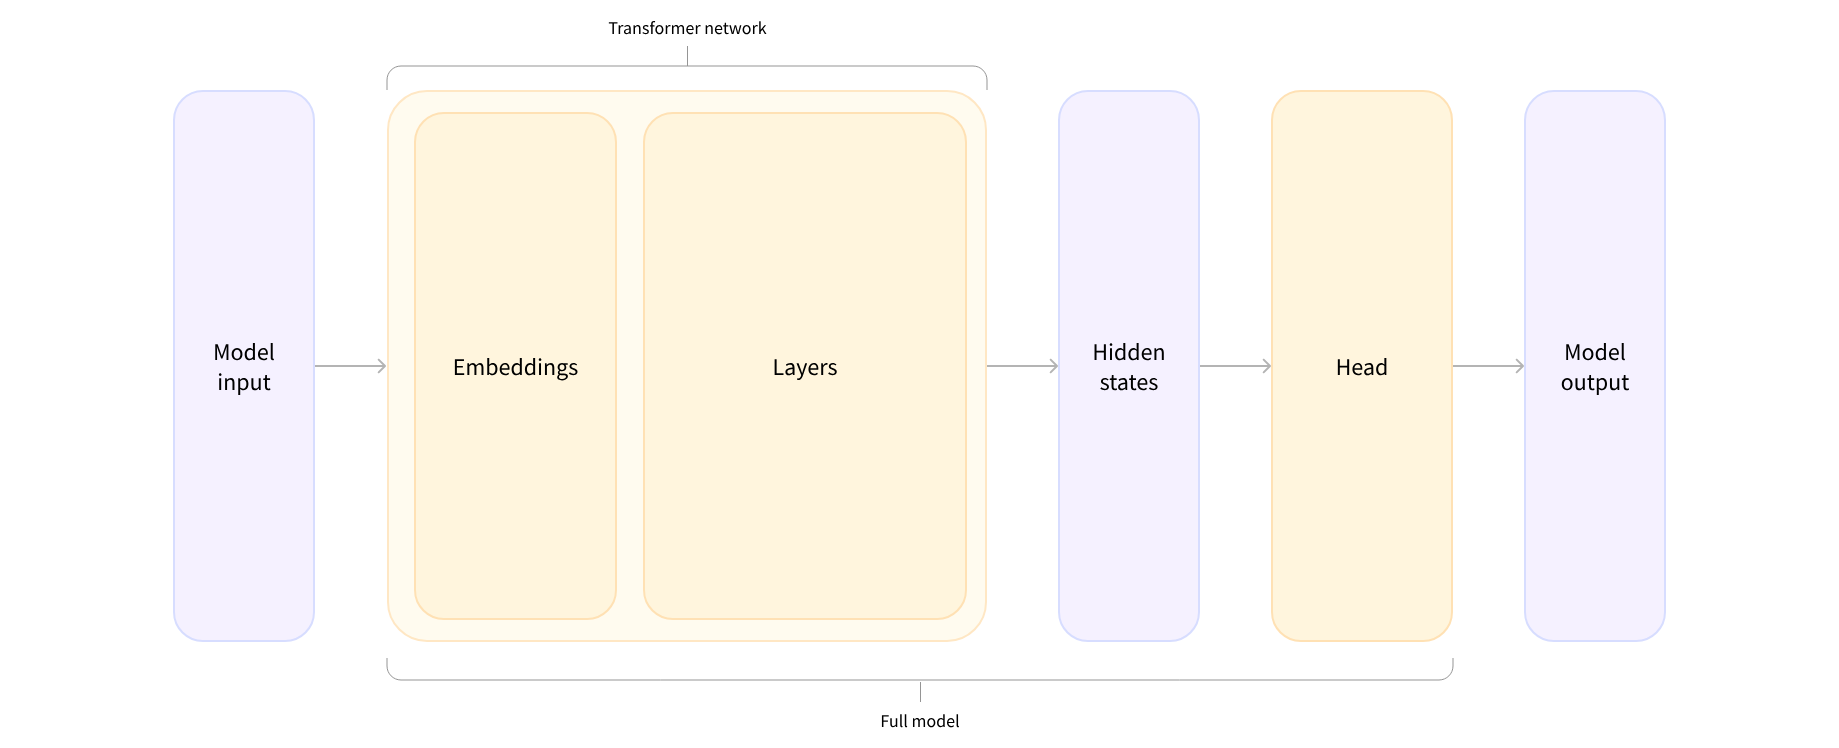

Here are some examples.
```
*
*ForMaskedLM
*ForSequenceClassification
*ForTokenClassification
*ForQuestionAnswering
*ForMultipleChoice
...
```
where `*` can be `AutoModel` or a specific pretrained model (e.g. `DistilBert`)


There are three types of models:
* Encoders (e.g. BERT)
* Decoders (e.g. GPT2)
* Encoder-Decoder models (e.g. BART or T5)

The task-specific classes you have available depend on what type of model you're dealing with.


A full list of choices are available in the [docs](https://huggingface.co/docs/transformers/model_doc/auto). Note that not all models are compatible with all model architectures, for example DistilBERT is not compatible with the Seq2Seq models because it only consists of an encoder.


In [ ]:
from transformers import AutoModelForSequenceClassification, DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)


We get a warning here because the sequence classification parameters haven't been trained yet.

Passing inputs to the model is super easy. They take inputs as keyword arguments

In [ ]:
model_inputs = tokenizer(input_str, return_tensors="pt")
# Option 1
model_outputs = model(input_ids=model_inputs.input_ids, attention_mask=model_inputs.attention_mask)

# Option 2 - the keys of the dictionary the tokenizer returns are the same as the keyword arguments
#            the model expects

# f({k1: v1, k2: v2}) = f(k1=v1, k2=v2)

model_outputs = model(**model_inputs)

print(model_inputs)
print()
print(model_outputs)
print()
print(f"Distribution over labels: {torch.softmax(model_outputs.logits, dim=1)}")

If you notice, it's a bit weird that we have two classes for a binary classification task - you could easily have a single class and just choose a threshold. It's like this because of how huggingface models calculate the loss. This will increase the number of parameters we have, but shouldn't otherwise affect performance.

These models are just Pytorch Modules! You can calculate the loss with your `loss_func` and call `loss.backward`. You can use any of the optimizers or learning rate schedulers that you used

In [ ]:
# You can calculate the loss like normal
label = torch.tensor([1])
loss = torch.nn.functional.cross_entropy(model_outputs.logits, label)
print(loss)
loss.backward()

# You can get the parameters
list(model.named_parameters())[0]

Hugging Face provides an additional easy way to calculate the loss as well:

In [ ]:
# To calculate the loss, we need to pass in a label: (Check if it returns same loss)
model_inputs = tokenizer(input_str, return_tensors="pt")

labels = ['NEGATIVE', 'POSITIVE']
model_inputs['labels'] = torch.tensor([1])

model_outputs = model(**model_inputs)


print(model_outputs)
print()
print(f"Model predictions: {labels[model_outputs.logits.argmax()]}")

One final note - you can get the hidden states and attention weights from the models really easily. This is particularly helpful if you're working on an analysis project. (For example, see [What does BERT look at?](https://arxiv.org/abs/1906.04341)).

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained("distilbert-base-cased", output_attentions=True, output_hidden_states=True)
model.eval() # set to eval mode => turn off dropout, do not update BatchNorm running statistics

model_inputs = tokenizer(input_str, return_tensors="pt")
with torch.no_grad(): # turn off gradient calculation
    model_output = model(**model_inputs)

print(model_inputs) # # of tokens: 9
print("Hidden state size (per layer):  ", model_output.hidden_states[0].shape)
print("Attention head size (per layer):", model_output.attentions[0].shape)     # (layer, batch, query_word_idx, key_word_idxs)
                                                                               # y-axis is query, x-axis is key
# print(model_output)

In [ ]:
#NOTE: plot is over (multi_head, layers)
tokens = tokenizer.convert_ids_to_tokens(model_inputs.input_ids[0])
print(tokens)


n_layers = len(model_output.attentions)
n_heads = len(model_output.attentions[0][0])
fig, axes = plt.subplots(6, 12)
fig.set_size_inches(18.5*2, 10.5*2)
for layer in range(n_layers):
    for i in range(n_heads):
        axes[layer, i].imshow(model_output.attentions[layer][0, i])
        axes[layer][i].set_xticks(list(range(9)))
        axes[layer][i].set_xticklabels(labels=tokens, rotation="vertical")
        axes[layer][i].set_yticks(list(range(9)))
        axes[layer][i].set_yticklabels(labels=tokens)

        if layer == 5:
            axes[layer, i].set(xlabel=f"head={i}")
        if i == 0:
            axes[layer, i].set(ylabel=f"layer={layer}")

plt.subplots_adjust(wspace=0.3)
plt.show()

## Part 1: Finetuning

For your projects, you are much more likely to want to finetune a pretrained model. This is a little bit more involved, but is still quite easy.

### 1.1 Loading in a dataset

In addition to having models, the [the hub](https://huggingface.co/datasets) also has datasets. You can load datasets with using the function load_dataset().

In [ ]:
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader


# DataLoader(zip(list1, list2))


imdb_dataset = load_dataset("imdb")


# Just take the first 50 tokens for speed/running on cpu (NOTE: It's a design choice)
def truncate(example):
    return {
        'text': " ".join(example['text'].split()[:50]),
        'label': example['label']
    }

# Take 128 random examples for train and 32 validation
small_imdb_dataset = DatasetDict(
    train=imdb_dataset['train'].shuffle(seed=1111).select(range(128)).map(truncate),
    val=imdb_dataset['train'].shuffle(seed=1111).select(range(128, 160)).map(truncate),
)

In [ ]:
small_imdb_dataset

In [ ]:
small_imdb_dataset['train'][:10]

In [ ]:
# Prepare the dataset - this tokenizes the dataset in batches of 16 examples.
small_tokenized_dataset = small_imdb_dataset.map(
    lambda example: tokenizer(example['text'], padding=True, truncation=True),
    batched=True,
    batch_size=16
)

small_tokenized_dataset = small_tokenized_dataset.remove_columns(["text"])
small_tokenized_dataset = small_tokenized_dataset.rename_column("label", "labels")
small_tokenized_dataset.set_format("torch")

In [ ]:
small_tokenized_dataset

In [ ]:
small_tokenized_dataset['train'][0:2]

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(small_tokenized_dataset['train'], batch_size=16)
eval_dataloader = DataLoader(small_tokenized_dataset['val'], batch_size=16)

### 2.2 Training

To train your models, you can just use the same kind of training loop that you would use in Pytorch. Hugging Face models are also `torch.nn.Module`s so backpropagation happens the same way and you can even use the same optimizers. Hugging Face also includes optimizers and learning rate schedules that were used to train Transformer models, so you can use these too.

For optimization, we're using the AdamW Optimizer, which is almost identical to Adam except it also includes weight decay.
And we're using a linear learning rate scheduler, which reduces the learning rate a little bit after each training step over the course of training.

There are other optimizers and learning rate schedulers you can use, but these are the default. If you want to explore, you can look at the ones [Hugging Face offers](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#schedules), the ones available through [Pytorch](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) (e.g. [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html), which only decreases the learning rate when the validation loss stops decreasing), or write your own.

In [ ]:
# Pytorch training
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import sys


model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

num_epochs = 3
num_training_steps = 3 * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

best_val_loss = float("inf")
progress_bar = tqdm(range(num_training_steps))
for epoch in range(num_epochs):
    # training
    model.train()
    for batch_i, batch in enumerate(train_dataloader):

        # batch = ([text1, text2], [0, 1])

        output = model(**batch)

        optimizer.zero_grad()
        output.loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)

    # validation
    model.eval()
    for batch_i, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            output = model(**batch)
        loss += output.loss

    avg_val_loss = loss / len(eval_dataloader)
    print(f"Validation loss: {avg_val_loss}")
    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            },
            f"checkpoints/epoch_{epoch}.pt"
        )

While you can use PyTorch to train your models, Hugging Face offers a powerful `Trainer` class to handle most needs. I think it works pretty well, though there are some customizations I'd recommend.

In [ ]:
imdb_dataset = load_dataset("imdb")

small_imdb_dataset = DatasetDict(
    train=imdb_dataset['train'].shuffle(seed=1111).select(range(128)).map(truncate),
    val=imdb_dataset['train'].shuffle(seed=1111).select(range(128, 160)).map(truncate),
)

small_tokenized_dataset = small_imdb_dataset.map(
    lambda example: tokenizer(example['text'], truncation=True),
    batched=True,
    batch_size=16
)

`TrainingArguments` specifies different training parameters like how often to evaluate and save model checkpoints, where to save them, etc. There are **many** aspects you can customize and it's worth checking them out [here](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments). Some things you can control include:
* learning rate, weight decay, gradient clipping,
* checkpointing, logging, and evaluation frequency
* where you log to (default is tensorboard, but if you use WandB or MLFlow they have integrations)

The `Trainer` actually performs the training. You can pass it the `TrainingArguments`, model, the datasets, tokenizer, optimizer, and even model checkpoints to resume training from. The `compute_metrics` function is called at the end of evaluation/validation to calculate evaluation metrics.

In [ ]:
from transformers import TrainingArguments, Trainer

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

arguments = TrainingArguments(
    output_dir="sample_hf_trainer",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=1,
    num_train_epochs=3,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    eval_steps=1,
    save_strategy="epoch",
    learning_rate=2e-5,
    load_best_model_at_end=True,
    seed=224
)


def compute_metrics(eval_pred):
    """Called at the end of validation. Gives accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # calculates the accuracy
    return {"accuracy": np.mean(predictions == labels)}


trainer = Trainer(
    model=model,
    args = arguments,
    train_dataset=small_tokenized_dataset['train'],
    eval_dataset=small_tokenized_dataset['val'], # change to test when you do your final evaluation!
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

#### Callbacks: Logging and Early Stopping


Hugging Face Transformers also allows you to write `Callbacks` if you want certain things to happen at different points during training (e.g. after evaluation or after an epoch has finished). For example, there is a callback for early stopping, and I usually write one for logging as well.

For more information on callbacks see [here](https://huggingface.co/docs/transformers/main_classes/callback#transformers.TrainerCallback).

In [ ]:
from transformers import EarlyStoppingCallback

# # you can do either a) include callbacks when you define a Trainer
# trainer = Trainer(
#     model=model,
#     args = arguments,
#     train_dataset=small_tokenized_dataset['train'],
#     eval_dataset=small_tokenized_dataset['val'], # change to test when you do your final evaluation!
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience =2)]
# )

# or b) add a callback after you define your Trainer
trainer.add_callback(EarlyStoppingCallback(early_stopping_patience =2))

In [ ]:
# train the model
trainer.train()

In [ ]:
# evaluating the model is very easy

# results = trainer.evaluate()                           # just gets evaluation metrics
results = trainer.predict(small_tokenized_dataset['val']) # also gives you predictions

In [ ]:
results

In [ ]:
# To load our saved model, we can pass the path to the checkpoint into the `from_pretrained` method:
test_str = "I enjoyed the movie!"

finetuned_model = AutoModelForSequenceClassification.from_pretrained("sample_hf_trainer/checkpoint-24") #NOTE: loading saved model from local direcotry
model_inputs = tokenizer(test_str, return_tensors="pt")
prediction = torch.argmax(finetuned_model(**model_inputs).logits)
print(["NEGATIVE", "POSITIVE"][prediction])

Included here are also some practical tips for fine-tuning:

**Good default hyperparameters.** The hyperparameters you will depend on your task and dataset. You should do a hyperparameter search to find the best ones. That said, here are some good initial values for fine-tuning.
* Epochs: {2, 3, 4} (larger amounts of data need fewer epochs)
* Batch size (bigger is better: as large as you can make it)
* Optimizer: AdamW
* AdamW learning rate: {2e-5, 5e-5}
* Learning rate scheduler: linear warm up for first {0, 100, 500} steps of training
* weight_decay (l2 regularization): {0, 0.01, 0.1}

You should monitor your validation loss to decide when you've found good hyperparameters.

There's a lot more that we can integrate into the Trainer to make it more useful including logging, saving model checkpoints, and more! You can even sub-class it to add your own personalized components. You can check out [this link](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer) for more information about the Trainer.

## Appendix 1: Generation

In the example above we finetuned the model on a classification task, but you can also finetune models on generation tasks. The `generate` function makes it easy to generate from these models. For example.

In [ ]:
# For higher version GPT such as GPT-3 or 4, you are required to call openai API.
from transformers import AutoModelForCausalLM

gpt2_tokenizer = AutoTokenizer.from_pretrained('gpt2')

gpt2 = AutoModelForCausalLM.from_pretrained('distilgpt2')
gpt2.config.pad_token_id = gpt2.config.eos_token_id  # Prevents warning during decoding

In [ ]:
prompt = "Once upon a time"

tokenized_prompt = gpt2_tokenizer(prompt, return_tensors="pt")

for i in range(10):
    output = gpt2.generate(**tokenized_prompt,
                  max_length=50,
                  do_sample=True,
                  top_p=0.9)

    print(f"{i + 1}) {gpt2_tokenizer.batch_decode(output)[0]}")

## Appendix 2: Masked Language Modeling

In [ ]:
import torch
import numpy as np
from transformers import AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", fast=True)
bert = AutoModelForMaskedLM.from_pretrained("bert-base-cased")

In [ ]:
prompt = "I am [MASK] to learn about HuggingFace!"
inputs = tokenizer(prompt, return_tensors="pt")
mask_index = np.where(inputs['input_ids'] == tokenizer.mask_token_id)
outputs = bert(**inputs)
top_5_predictions = torch.softmax(outputs.logits[mask_index], dim=1).topk(5)

print(prompt)
for i in range(5):
    prediction = tokenizer.decode(top_5_predictions.indices[0, i])
    prob = top_5_predictions.values[0, i]
    print(f"  {i+1}) {prediction}\t{prob:.3f}")

## Appendix 3: Pipelines (For inference)

There are some standard NLP tasks like sentiment classification or question answering where there are already pre-trained (and fine-tuned!) models available through Hugging Face Transformer's [_Pipeline_](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/pipelines#transformers.pipeline) interface.

For your projects, you likely won't be using it too much, but it's still worth knowing about!

Here's an example with Mask Infilling:

In [ ]:
from transformers import pipeline

unmasker = pipeline("fill-mask")

from pprint import pprint

pprint(
    unmasker(
        f"HuggingFace is creating a {unmasker.tokenizer.mask_token} that the community uses to solve NLP tasks."
    )
),

Here's an example with Sentiment Analysis:

In [ ]:
from transformers import pipeline

senti_analysis_pipe = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")
senti_analysis_pipe("Hugging Face Transformers is really cool!")

Or on a list of strings:

In [ ]:
senti_analysis_pipe(["I didn't know if I would like Hákarl, but it turned out pretty good.",
                    "I didn't know if I would like Hákarl, and it was just as bad as I'd heard."])

## Appendix 4: Defining Custom Datasets

There are a few ways to go about defining datasets, but I'm going to show an example using Pytorch Dataloaders. This example uses an encoder-decoder dataaset,the [E2E Dataset](https://arxiv.org/abs/1706.09254), which is maps structured information about restaurants to natural language descriptions.

In [ ]:
!wget https://raw.githubusercontent.com/tuetschek/e2e-dataset/master/trainset.csv

In [ ]:
from glob import glob
glob('/content/*')

In [ ]:
# Option 1: Load into Hugging Face Datasets

import pandas as pd
from datasets import Dataset

df = pd.read_csv("/content/trainset.csv")
custom_dataset = Dataset.from_pandas(df)

In [ ]:
from transformers import AutoTokenizer

In [ ]:
import csv
from torch.utils.data import Dataset, DataLoader

class E2EDataset(Dataset):
    """Tokenize data when we call __getitem__"""
    def __init__(self, path, tokenizer):
        with open(path, newline="") as f:
            reader = csv.reader(f)
            next(reader) # skip the heading
            self.data = [{"source": row[0], "target": row[1]} for row in reader]
        self.tokenizer = tokenizer

    def __getitem__(self, i):
        inputs = self.tokenizer(self.data[i]['source'])
        labels = self.tokenizer(self.data[i]['target'])
        inputs['labels'] = labels.input_ids
        return inputs


In [ ]:
bart_tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')

In [ ]:
bart_tokenizer(["This is the first test.", "This is the second test."], text_target=["Target 1", "Target 2"], return_tensors="pt")

In [ ]:
dataset = E2EDataset("/content/trainset.csv", bart_tokenizer)

In [ ]:
dataset[0]

In [ ]:
print(bart_tokenizer.decode(dataset[0]['input_ids']))
print(bart_tokenizer.decode(dataset[0]['labels']))

You can find more information on pipelines (including which ones are available) [here](https://huggingface.co/docs/transformers/main_classes/pipelines)